# TP n°2: Ségmentation sémantique et ViBe - Comparaison
**Membres:**
- Guillaume Girouard 1954899
- Pierre-Emmanuel Rebours 2165286


# Sommaire :
1. [Fonctions utilitaires](#fct-ut)
2. [Segmentation sémantique](#seg-sem)
    1. [Implémentation des méthodes](#impl-sem-seg)
    2. [Obtension des résultats](#res-sem-seg)
3. [Soustraction d'arrière-plan (Vibe)](#vibe)
    1. [Implémentation des méthodes](#impl-vibe)
    2. [Optimisation](#opti-vibe)
    3. [Obtension des résultats](#res-vibe)
4. [Mesure des performances](#performance)
    1. [Pour le label "highway"](#perf-highway)
    2. [Pour le label "pedestrians"](#perf-pedestrians)
    3. [Pour le label "office"](#perf-office)
    4. [Pour le label "PETS2006"](#perf-pets)

In [2]:

%pip install torch
%pip install torchvision

^C
Note: you may need to restart the kernel to use updated packages.
  Using cached torchvision-0.14.1-cp310-cp310-win_amd64.whl (1.1 MB)
Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\ggiro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


     -------------------------------------- 162.6/162.6 MB 9.8 MB/s eta 0:00:00
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27 kB)


You should consider upgrading via the 'c:\Users\ggiro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:
%pip install --upgrade numpy

^C
Note: you may need to restart the kernel to use updated packages.


     --------------------------------------- 14.8/14.8 MB 10.7 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.3
    Uninstalling numpy-1.22.3:
      Successfully uninstalled numpy-1.22.3


You should consider upgrading via the 'c:\Users\ggiro\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [1]:

import matplotlib.pyplot as plt
import numpy as np 
from pathlib import Path

from PIL import Image,ImageOps
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from skimage import io
import os
import cv2

c:\Users\pierr\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Fonctions utilitaires <a class="anchor" id="fct-ut"></a>

On commence par implémenter de simple fonction utilitaire por obtenir le chemin vers toutes les frames de l'input, de l'output et du groundtruth:

In [3]:
pathToCategories = "./baseline/baseline/"
def init_dataset(labels):
    """
    fonction pour récupérer le chemin vers les données d'entrée et les données de validation de la segmentaiton (groundtruth)
    Args:
        labels: labels des vidéos dont on veut récupérer les données.
    """
    input_data = {}
    groundTruth_data = {}
    nb_image = {}
    i=0
    for label in labels:
        input_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/input/").glob('*.jpg')]
        groundTruth_data[label] = [str(p) for p in Path(
            pathToCategories+label+"/groundtruth/").glob('*.png')]
        nb_image[label] = len(input_data[label])
    return nb_image,input_data,groundTruth_data


In [4]:
def output_dataset(labels):
    """
    fonction pour récupérer le chemin vers les données obtenue en sortie des méthodes de segmentation implémentés
    Args:
        labels: labels des vidéos dont on veut récupérer les données.
    """
    output_data_sem_seg = {}
    output_data_vibe = {}
    nb_image = {}
    i=0
    for label in labels:
        output_data_sem_seg[label] = [str(p) for p in Path(
            pathToCategories+label+"/output_sem_seg/").glob('*.jpg')]
        output_data_vibe[label] = [str(p) for p in Path(
            pathToCategories+label+"/output_vibe/").glob('*.jpg')]
        #nb_image[label] = len(output_data_sem_seg[label])
    return output_data_sem_seg,output_data_vibe

In [9]:
nb_image,input_data,groundTruth_data=init_dataset(labels)

In [99]:
def PercentageCorrectClassification(img,groundtruth):
    res=np.unique(img.astype(float)-groundtruth.astype(float),return_counts=True)
    #FN=res[1][0]
    #TPandTN=res[1][1]
    #FP=res[1][2]
    count={0:0,-1:0,254:0,-255:0}
    for i in range(len(res[0])):
        count[res[0][i]]=res[1][i]
        FN=count[-255]
        TN=count[-1]
        TP=count[0]
        FP=count[254]
    PCC=(TP+TN)/(TP+TN+FP+FN)
    return PCC

In [71]:
def classifactionMetrics(img,groundtruth):
    groundtruth_c=np.copy(groundtruth)
    groundtruth_c[groundtruth_c==0]=1 #pour pouvoir distinguer TN de TP
    res=np.unique(img.astype(float)-groundtruth_c.astype(float),return_counts=True)
    #FN=res[1][0]
    #TN=res[1][1]
    #TP=res[1][2]
    #FP=res[1][3]
    count={0:0,-1:0,254:0,-255:0}
    for i in range(len(res[0])):
        count[res[0][i]]=res[1][i]
        FN=count[-255]
        TN=count[-1]
        TP=count[0]
        FP=count[254]
    print(FP)
    precision=TP/(TP+FP)
    recall=TP/(TP+FN)
    f1_score=2*precision*recall/(precision+recall)
    return precision,recall,f1_score

On implémente également une méthode pour calculer l'indice de Jaccard

In [5]:
def jaccardCoeff(img,groundtruth,positiveClass="foreground"):
    """
    fonction pour mesurer l'indice de Jaccard pour une segmenation donnée
    Args:
        img: image qui contient la segmentation dont on veut mesurer l'indice
        groundtruth: solution de la segmentation
        positiveClass: partie de la segmentation que l'on considère comme la calsse positive.
        Par défaut, il s'agit du premier-plan (régions d'intérets).
    """
    groundtruth_c=np.copy(groundtruth)
    groundtruth_c[groundtruth_c==0]=1 #pour pouvoir distinguer TN de TP
    res=np.unique(img.astype(float)-groundtruth_c.astype(float),return_counts=True)
    count={0:0,-1:0,254:0,-255:0}
    for i in range(len(res[0])):
        count[res[0][i]]=res[1][i]
        FN=count[-255]
        TN=count[-1]
        TP=count[0]
        FP=count[254]
    if positiveClass=="foreground":
        if (TP+FP+FN)==0:
            coeff=1
        else:
            coeff=TP/(TP+FP+FN)
    else:
        coeff=TN/(TN+FP+FN)
    return coeff

### Segmentation sémantique <a class="anchor" id="seg-sem"></a>

#### Implémentation des méthodes <a class="anchor" id="impl-seg-sem"></a>

In [ ]:
#fonction appliquant du pre-traitement aux cathegories dimage recu et retournant la liste des images retransforme en Tensor

preprocessing = transforms.Compose([
    transforms.ToTensor(),
])

def get_input_tensor(input_data):
    input_tensor_label = {}
    input_tensor_label = []
    for input in input_data:
        tensor = preprocessing(Image.fromarray(io.imread(input)))
        input_tensor_label.append(tensor)
    return input_tensor_label

In [ ]:
# retourne les images en batch empiler pour envoyer à l'analyse
def stack_input_tensor(input_tensor_label):
    input_batch_tensor_label=torch.stack(input_tensor_label, 0)
    return input_batch_tensor_label


In [ ]:
#applique l'analyse de la segmentation semantique avec le modele DeepLabV3 prenant comme squellette le reseau resnet101
def evaluate(input_batch_tensor_label):
    model = models.segmentation.deeplabv3_resnet101(pretrained=True).eval()
    predictions = {}
    with torch.no_grad():
        predictions = model(input_batch_tensor_label)
    return predictions

In [ ]:
#fonction de coloration des regions dinteret apres la segmentation
def draw_segmentation_mask(image,nb_class):
  name_colors=list(mcolors.CSS4_COLORS.keys())[7+1:7+nb_class]
  rgb_colors=np.array([(np.array(mcolors.to_rgb(i))*255).astype("uint8") for i in name_colors])
  COLORS = np.vstack([[0, 0, 0], rgb_colors]).astype("uint8")
  COLORS[15] = [255,255,255] #class pour lidentification de personnes
  image.putpalette(COLORS)
  return image

#### Récupération des résultats <a class="anchor" id="res-sem-seg"></a>

In [ ]:
#fonction principale dacquisition des resultats pour la segmentation sementique, les resultats sont mis dans le dossier "output_seg_sem"
labels = ["highway", "office", "pedestrians", "PETS2006"]
batchSize = 4 #nombre d'images prises par batch d'analyse de segmentation
print("initialising dataset: ",labels," with batchSize = ",batchSize)
nb_image, input_data, true_data = init_dataset(labels) # recuperation du repertoire des data et du nombre dimage a traiter
mini_input_data={}
for label in labels:
    print("current label :",label)
    current = 0 # position de limage se faisant traiter
    anounce_ID =250 # donne un indice de progression a vhaque 250 images traitées
    while(current < nb_image[label]):
        if current > anounce_ID:
            print("are now at", anounce_ID)
            anounce_ID +=250
        if (current+batchSize) > nb_image[label]: #prend en consideration de sil reste moins de 4 images a traiter
            mini_input_data[label]=input_data[label][current:-1]
            current = nb_image[label]
        else:
            mini_input_data[label]=input_data[label][current:(current+batchSize)]
            current += batchSize

        input_tensor_label = get_input_tensor(mini_input_data[label]) #convertie les images en tensor
        input_batch_tensor_label = stack_input_tensor(input_tensor_label) # empiles les images
        predictions = evaluate(input_batch_tensor_label) # applique la prediction
        nb_class = predictions['out'].shape[1]
        for i in range(len(mini_input_data[label])):
            prediction = torch.argmax(predictions['out'][i].squeeze(), dim=0).detach().cpu().numpy().astype(np.uint8)
            masks = Image.fromarray(prediction)
            segmentation_mask=draw_segmentation_mask(masks,nb_class) # dessine les regions dinteret
            segmentation_mask = ImageOps.grayscale(segmentation_mask) # convertie la couleur des regions en grayscale
            segmentation_mask.save(mini_input_data[label][i].replace("input","output_sem_seg"),format="PNG") #enregistre limage




initialising dataset:  ['highway']  with batchSize =  4
current label : highway
are now at 250
are now at 500
are now at 750
are now at 1000
are now at 1250
are now at 1500


### Soustraction d'arrière-plan <a class="anchor" id="vibe"></a>

La présente section s'attarde sur l'implémentation, l'optimisation et l'obtention des résultats de la méthode ViBe.

#### Implémentation des méthodes <a class="anchor" id="impl-vibe"></a>

On commence par créer une fonction pour l'initialisation:

In [9]:
from random import randrange
import random
def initBackground(frame,nb_samples,gray_scale=False):
    """
    Cette méthode permet d'initialiser le modèle de l'arrière plan pour la méthode ViBe.
    Args:
        frame: première frame, utilisé pour initialiser le modèle.
        nb_samples: nombre d'échantillons pour une position dans le modèle 
        gray_scale: si les frames du jeux de données sont en niveau de gris
    """
    frame_size=np.shape(frame)

    if gray_scale:
        #Si le jeux de données sont en niveau de gris 
        background=np.empty((frame_size[0],frame_size[1],nb_samples))    
    else:
        #Si le jeux de données sont RGB
        background=np.empty((frame_size[0],frame_size[1],nb_samples,3))
    
    #Pour chaque position dans la frame: on pioche un voisin au hasard pour chaque échantillon du modèle d'arrière-plan
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            #Si la position n'est pas sur le coté bas ou droit de la frame
            if i<frame_size[0]-1 and j<frame_size[1]-1:
                #Si la position n'est pas sur le coté haut ou gauche de la frame
                if i>=1 and j>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coté gauche de la frame       
                elif i>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coté haut de la frame 
                elif j>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est dans le coin supérieur gauche de la frame
                else:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([          [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            #Si la position est sur le coté droit de la frame 
            elif i<frame_size[0]-1:
                #Si la position n'est pas sur le coté haut de la frame 
                if i>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j],])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coin supérieur droit de la frame 
                else:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i, j-1], 
                                                  [i+1, j-1], [i+1, j]])
                        background[i,j,k]=frame[i_n,j_n]
            #Si la position est sur le coté bas de la frame 
            elif j<frame_size[1]-1:
                #Si la position n'est pas sur le coté gauche de la frame 
                if j>=1:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
                #Si la position est sur le coin inférieur gauche de la frame 
                else:
                    for k in range(nb_samples):
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        background[i,j,k]=frame[i_n,j_n]
            else:
                #Si la position est sur le coin inférieur droit de la frame 
                for k in range(nb_samples):
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])
                    background[i,j,k]=frame[i_n,j_n]

    return background      




On implémente ensuite le coeur de la méthode. La fonction suivante segmente une frame et update aléatoirement des échantillons du modèle d'arrière-plan:

In [10]:
def segmentationViBe4(frame,background_model,R,seuil,nb_samples,random_subsampling):
    """
    Cette méthode permet d'appliquer une segmentation binaire par la méthod ViBe de la frame passé en argument.
    Args:
        frame: frame dont on veut connaitre la segmentation.
        background_model: modèle d'arrière plan
        R: rayon de la sphère pour déterminer la proximité d'un pixel avec les échantillons du modèle
        seuil: nombre d'échantillon à l'intérieur de la sphère à partit duquel on considère que le pixel
               (le centre de la sphère) appartient à l'arrière plan 
        nb_samples: nombre d'échantillons pour une position dans le modèle 
        random_subsampling: la probilité que le modèle, à une position donnée, soit mis à jour est de 1/random_subsampling
    """

    frame_size=np.shape(frame)
    res=np.empty((frame_size[0],frame_size[1]))
    #R2=R**2

    #Pour chaque position dans la frame
    for i in range(frame_size[0]):
        for j in range(frame_size[1]):
            center=frame[i,j]#Le centre de la sphère est le pixel de la frame à la position courante (,j)
            count=0
            #Pour chaque échantillon dans le modèle d'arrière plan à la position (i,j)
            for sample in background_model[i,j]:
                dist_with_center=(np.linalg.norm(center-sample))
                #Si la distance du centre à l'échantillon est inférieur au rayon de la sphère, on incrémente le compteur
                if dist_with_center<R:
                    count+=1
                if count>=seuil:
                    break
            #Si le compteur est supérieur au seuil, on considère que le pixel appartient à l'arrière-plan
            if count>=seuil:
                res[i,j]=0
            else:
                res[i,j]=255

            #Mise à jour du modèle d'arrière plan avec la probabilité 1/random_subsampling    
            update = randrange(random_subsampling)
            if update == 0:
                #l'échantillon qui est mis à jour est tiré au sort
                sample = randrange(nb_samples)
                background_model[i, j, sample] = frame[i, j]

            #Mise à jour du modèle de l'arrièe-plan pour une position voisine de la position actuelle 
            # avec la probabilité 1/random_subsampling     
            update = randrange(random_subsampling)
            if update == 0:
                #L'échantillon qui sera mis à jour est tiré au sort
                sample=randrange(nb_samples)   
                if i < frame_size[0]-1 and j < frame_size[1]-1:
                    if i >= 1 and j >= 1:
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    elif i >= 1:
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                  [i, j+1],
                                                  [i+1, j], [i+1, j+1]])

                    elif j >= 1:
                        #neighbours = frame[i:i+2, j-1:j+2]
                        i_n, j_n = random.choice([[i, j-1], [i, j+1],
                                                  [i+1, j-1], [i+1, j], [i+1, j+1]])

                    else:
                        #neighbours = frame[i:i+2, j:j+2]
                        i_n, j_n = random.choice([            [i, j+1],
                                                  [i+1, j], [i+1, j+1]])
               
                elif i < frame_size[0]-1:
                    if i >= 1:
                        #neighbours = frame[i-1:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                                  [i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                    
                    else:
                        #neighbours = frame[i:i+2, j-1:j+1]
                        i_n, j_n = random.choice([[i, j-1],
                                                  [i+1, j-1], [i+1, j]])
                        
                elif j < frame_size[1]-1:
                    if j >= 1:
                        #neighbours = frame[i-1:i+1, j-1:j+2]
                        i_n, j_n = random.choice([[i-1, j-1], [i-1, j], [i-1, j+1],
                                                  [i, j-1],             [i, j+1]])
                        
                    else:
                        #neighbours = frame[i-1:i+1, j:j+2]
                        i_n, j_n = random.choice([[i-1, j], [i-1, j+1],
                                                            [i, j+1]])
                        
                else:
                    #neighbours = frame[i-1:i+1, j-1:j+1]
                    i_n, j_n = random.choice([[i-1, j-1], [i-1, j],
                                              [i, j-1]             ])

                
                
                background_model[i_n,j_n,sample]=frame[i,j]
    return res


In [6]:
labels=["highway", "office", "pedestrians", "PETS2006"]
nb_images,input_data,groundTruth_data=init_dataset(labels)

In [ ]:
import cv2
resize_relation=1

img=io.imread(input_data["highway"][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=20
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data["highway"][500:600]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    #res=segmentationViBe2(img,background,0.15,2,nb_samples)
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
for input in input_data["highway"][600:1100]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    #res=segmentationViBe2(img,background,0.15,2,nb_samples)
    res=segmentationViBe4(img,background,20,2,nb_samples,16)
    #Image.fromarray(res).convert('L').save(input.replace("input","output_vibe"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()
    plt.imshow(res,cmap='gray')
    plt.show()


#### Optimisation <a class="anchor" id="opti-vibe"></a>

In [8]:
def plot_hyperparameter_tuning(res,x_label_orientation="horizontal",x_axis_title="Hyper-parameter value"):
    """
    Montre le graph issu de la recherche d'hyperparamètres.

    Args:
        res: dictionnaire où pour une clé correspondant à la valeur donnée à l'hyperparamètre associe 
             le taux moyen d'images correctes obtenu avec ce dernier.
        x_label_orientation: orientation de label de l'axe horizontale ("vertical" ou "horizonal")
        x_axis_title: titre de l'axe des abscisses
    
    """
    plt.plot(res.keys(),res.values(),'-ro')
    keys_with_max=[key for key,value in res.items() if abs(value-max(res.values()))<1e-09]
    print("On obtient l'indice de Jaccard maximal: "+str(max(res.values()))+" pour les valeurs d'hyperparamètre suivantes:\n"+str(keys_with_max))
    for key in keys_with_max:
        axv=plt.axvline(key, color="red", ls="--")
    if x_label_orientation=="vertical":
        plt.xticks(rotation=90)
    plt.ylabel("Indice de Jaccard")
    plt.xlabel(x_axis_title)
    axv.set_label("Meilleure configuration")
    plt.legend()
    plt.show()

On commence par faire varier le nombre d'échantillons

In [97]:
jaccard_coeff2={}
resize_relation=2

for nb_samples in [5,10,15,20,25,30,35,40]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff2[nb_samples]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(jaccard_coeff2[nb_samples]))

the mean jaccard's coefficient for hyperparameter value=5 is 0.42623877233406804
the mean jaccard's coefficient for hyperparameter value=10 is 0.5851030471578137
the mean jaccard's coefficient for hyperparameter value=15 is 0.6012267736855265
the mean jaccard's coefficient for hyperparameter value=20 is 0.6031697442397256
the mean jaccard's coefficient for hyperparameter value=25 is 0.6041443982204235
the mean jaccard's coefficient for hyperparameter value=30 is 0.6041860212603415
the mean jaccard's coefficient for hyperparameter value=35 is 0.6093627068162963
the mean jaccard's coefficient for hyperparameter value=40 is 0.6109037554909962


In [98]:
for nb_samples in [45,50,55,50]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,2,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff2[nb_samples]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(nb_samples)+" is "+str(jaccard_coeff2[nb_samples]))

the mean jaccard's coefficient for hyperparameter value=45 is 0.6088637825253821
the mean jaccard's coefficient for hyperparameter value=50 is 0.6080759206833604
the mean jaccard's coefficient for hyperparameter value=55 is 0.6089661047869036
the mean jaccard's coefficient for hyperparameter value=50 is 0.6083699199575535


On obtient l'indice de Jaccard maximal: 0.6109037554909962 pour les valeurs d'hyperparamètre suivantes:
[40]


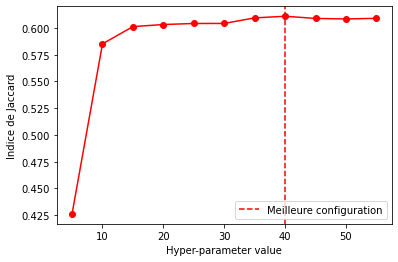

In [99]:
plot_hyperparameter_tuning(jaccard_coeff2)

Au vu des résultats précédent, on fixe le nombre d'échantillons à 40. \
On fait à présent varier le seuil à partir du quel le nombre d'échantillon jugé proche d'un pixel est synonyme du fait que l'on considère ce pixel comme appartenant à l'arrière-plan.

In [100]:
jaccard_coeff3={}
resize_relation=2
nb_samples=40

for value in [1,2,4,6,8,10,12,15]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,value,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,20,value,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff3[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff3[value]))

the mean jaccard's coefficient for hyperparameter value=1 is 0.5247362268062862
the mean jaccard's coefficient for hyperparameter value=2 is 0.6080375943924514
the mean jaccard's coefficient for hyperparameter value=4 is 0.6190609071574038
the mean jaccard's coefficient for hyperparameter value=6 is 0.5748565559830896
the mean jaccard's coefficient for hyperparameter value=8 is 0.5073819634432732
the mean jaccard's coefficient for hyperparameter value=10 is 0.42766267768800936
the mean jaccard's coefficient for hyperparameter value=12 is 0.33860149414436974
the mean jaccard's coefficient for hyperparameter value=15 is 0.23266036456039474


On obtient l'indice de Jaccard maximal: 0.6190609071574038 pour les valeurs d'hyperparamètre suivantes:
[4]


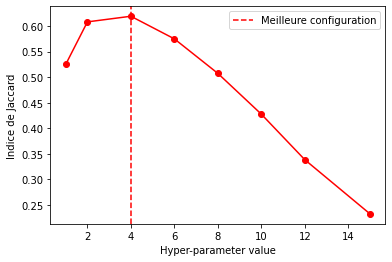

In [101]:
plot_hyperparameter_tuning(jaccard_coeff3)

On fixe le seuil à 4 et on fait maintenant varier le rayon de la sphère dans laquelle les échantillons sont considéré comme proche de son centre.

In [14]:
jaccard_coeff4={}
resize_relation=2
nb_samples=40
seuil=4

for value in [10,20,25,30,35,40,45,50,55,60,65]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,value,seuil,nb_samples,16)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff4[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff4[value]))

the mean jaccard's coefficient for hyperparameter value=10 is 0.4485130237126565
the mean jaccard's coefficient for hyperparameter value=20 is 0.6194223648821724
the mean jaccard's coefficient for hyperparameter value=25 is 0.6458666206129723
the mean jaccard's coefficient for hyperparameter value=30 is 0.6612591326401006
the mean jaccard's coefficient for hyperparameter value=35 is 0.6732821005723987
the mean jaccard's coefficient for hyperparameter value=40 is 0.6818576156241567
the mean jaccard's coefficient for hyperparameter value=45 is 0.6915770685143042
the mean jaccard's coefficient for hyperparameter value=50 is 0.6950680426971242
the mean jaccard's coefficient for hyperparameter value=55 is 0.689321738292107
the mean jaccard's coefficient for hyperparameter value=60 is 0.6848548389636163
the mean jaccard's coefficient for hyperparameter value=65 is 0.6810435079584206


On obtient l'indice de Jaccard maximal: 0.6950680426971242 pour les valeurs d'hyperparamètre suivantes:
[50]


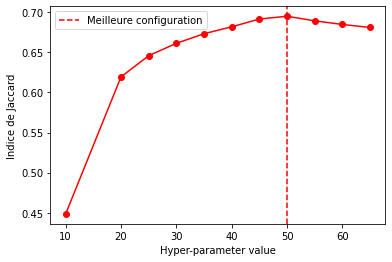

In [17]:
plot_hyperparameter_tuning(jaccard_coeff4)

On fixe donc le rayon à 30. \
On fait enfin varier la probabilité de mettre à jour le modèle:

In [18]:
jaccard_coeff5={}
resize_relation=2
nb_samples=40
seuil=4
rayon=50

for value in [5,10,16,20,25,30]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

the mean jaccard's coefficient for hyperparameter value=5 is 0.6023484113615829
the mean jaccard's coefficient for hyperparameter value=10 is 0.6701033875636467
the mean jaccard's coefficient for hyperparameter value=16 is 0.6943224888955757
the mean jaccard's coefficient for hyperparameter value=20 is 0.6995582986720221
the mean jaccard's coefficient for hyperparameter value=25 is 0.7030235850011743
the mean jaccard's coefficient for hyperparameter value=30 is 0.703806400434971


In [20]:
for value in [35,40,45,50]:
    coeff_moy=0
    coeff={}
    label="PETS2006"
    
    #if label=="PETS2006":
     #   resize_relation=2
    #else:
     #   resize_relation=1
    
    coeff[label]=[]
    img=io.imread(input_data[label][0])#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    background=initBackground(img,nb_samples)#,gray_scale=True)
    for i in range(600,700):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
    for i in range(700,731):
        input=input_data[label][i]
        groundtruth=io.imread(groundTruth_data[label][i])
        groundtruth[groundtruth>=50]=255
        img=io.imread(input)#,as_gray=True)
        img_shape=np.shape(img)
        img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        groundtruth=cv2.resize(groundtruth,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
        #res=segmentationViBe2(img,background,0.15,2,nb_samples)
        res=segmentationViBe4(img,background,rayon,seuil,nb_samples,value)
        coeff[label].append(jaccardCoeff(res,groundtruth))
    jaccard_coeff5[value]=np.mean(coeff[label])
    print("the mean jaccard's coefficient for hyperparameter value="+str(value)+" is "+str(jaccard_coeff5[value]))

the mean jaccard's coefficient for hyperparameter value=35 is 0.7029790797834545
the mean jaccard's coefficient for hyperparameter value=40 is 0.7031447329226498
the mean jaccard's coefficient for hyperparameter value=45 is 0.7022897110752099
the mean jaccard's coefficient for hyperparameter value=50 is 0.6998394234515632


On obtient l'indice de Jaccard maximal: 0.703806400434971 pour les valeurs d'hyperparamètre suivantes:
[30]


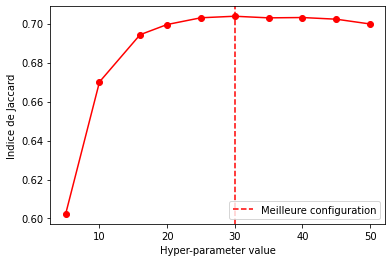

In [21]:
plot_hyperparameter_tuning(jaccard_coeff5)

On fixe donc la probabilité de mise-à-jour à 1/30

#### Obtention des résultats <a class="anchor" id="res-vibe"></a>

On applique la segmentation en prenant soin de sauvegarder les résultats dans des dossiers prévu à cet effet: \
Pour chaque label, on a un dossier output_vibe avec les segmentation faites par ViBe.

In [35]:
import cv2
resize_relation=1
label="highway"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")



In [63]:
import cv2
resize_relation=1
label="pedestrians"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [18]:
import cv2
resize_relation=1
label="office"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")
    #plt.imshow(img,cmap='gray')
    #plt.show()


In [16]:
import cv2
resize_relation=1
label="PETS2006"

img=io.imread(input_data[label][0])#,as_gray=True)
img_shape=np.shape(img)
img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
nb_samples=40
background=initBackground(img,nb_samples)#,gray_scale=True)
for input in input_data[label]:
    img=io.imread(input)#,as_gray=True)
    img_shape=np.shape(img)
    img=cv2.resize(img,(img_shape[1]//resize_relation,img_shape[0]//resize_relation))
    res=segmentationViBe4(img,background,50,4,nb_samples,30)
    Image.fromarray(res).convert('L').save(input.replace("input","output_vibe").replace("in0","out0"),format="PNG")


### Mesure des performances <a class="anchor" id="performance"></a>

Dans la présente section, on détermine l'indice de Jaccard de chaque frame et on affiche des graphs et valeurs nécessaires à la comparaison des 2 méthodes dans le rapport.

In [6]:
labels=["highway", "office", "pedestrians", "PETS2006"]
output_data_sem_seg,output_data_vibe=output_dataset(labels)

#### Pour le label "highway" <a class="anchor" id="perf-highway"></a>

In [85]:
label="highway"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][469:]
for i in range(len(groundtruth_of_label)):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+469])
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+469])
    grdtruth=io.imread(groundtruth_of_label[i])
    grdtruth_c=np.copy(grdtruth)
    grdtruth_c[grdtruth_c>=50]=255
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth_c))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

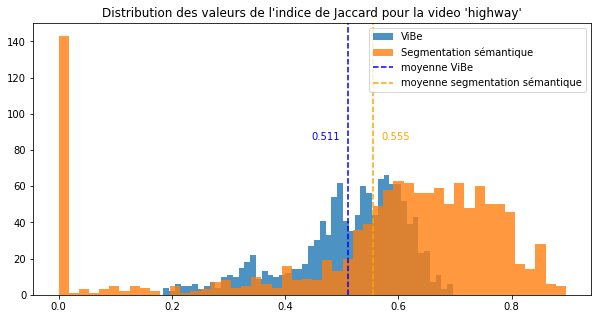

In [86]:
plt.figure(figsize=(10,5))
plt.hist(jaccard_coeff_vibe,bins=50,alpha=0.8,label="ViBe")
plt.hist(jaccard_coeff_sem_seg,bins=50,alpha=0.8,label="Segmentation sémantique")
plt.axvline(np.mean(jaccard_coeff_vibe), color="blue", ls="--",label="moyenne ViBe")
plt.axvline(np.mean(jaccard_coeff_sem_seg), color="orange", ls="--",label="moyenne segmentation sémantique")
plt.text(np.mean(jaccard_coeff_vibe)-0.04,90, "{:.3f}".format(np.mean(jaccard_coeff_vibe)), color='blue',
            ha='center', va='top')
plt.text(np.mean(jaccard_coeff_sem_seg)+0.04,90, "{:.3f}".format(np.mean(jaccard_coeff_sem_seg)), color='orange',
            ha='center', va='top')
plt.title("Distribution des valeurs de l'indice de Jaccard pour la video 'highway'")
plt.legend()
plt.show()

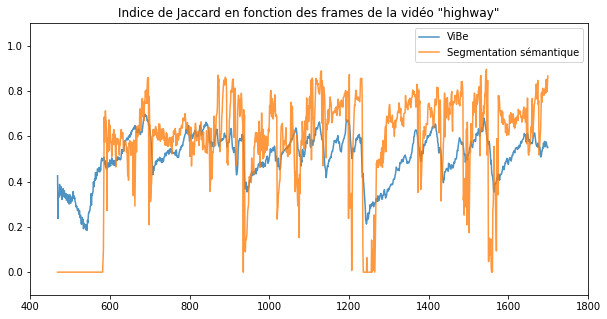

In [72]:
plt.figure(figsize=(10,5))
plt.plot(range(469,len(groundtruth_of_label)+469),jaccard_coeff_vibe,alpha=0.8,label="ViBe")
plt.plot(range(469,len(groundtruth_of_label)+469),jaccard_coeff_sem_seg,alpha=0.8,label="Segmentation sémantique")
plt.title('Indice de Jaccard en fonction des frames de la vidéo "highway"')
plt.ylim([-0.1,1.1])
plt.xlim([400,1800])
plt.legend()
plt.show()

#### Pour le label "pedestrians" <a class="anchor" id="perf-pedestrians"></a>

In [10]:
label="pedestrians"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][299:]
for i in range(len(groundtruth_of_label)-1):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+299])
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+299])
    grdtruth=io.imread(groundtruth_of_label[i])
    grdtruth[grdtruth<=170]=0
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

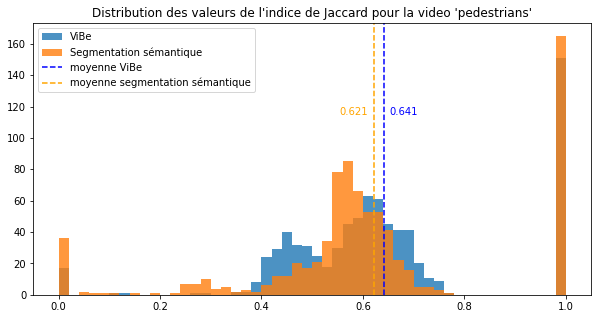

In [11]:
plt.figure(figsize=(10,5))
plt.hist(jaccard_coeff_vibe,bins=50,alpha=0.8,label="ViBe")
plt.hist(jaccard_coeff_sem_seg,bins=50,alpha=0.8,label="Segmentation sémantique")
plt.axvline(np.mean(jaccard_coeff_vibe), color="blue", ls="--",label="moyenne ViBe")
plt.axvline(np.mean(jaccard_coeff_sem_seg), color="orange", ls="--",label="moyenne segmentation sémantique")
plt.text(np.mean(jaccard_coeff_vibe)+0.04,120, "{:.3f}".format(np.mean(jaccard_coeff_vibe)), color='blue',
            ha='center', va='top')
plt.text(np.mean(jaccard_coeff_sem_seg)-0.04,120, "{:.3f}".format(np.mean(jaccard_coeff_sem_seg)), color='orange',
            ha='center', va='top')
plt.title("Distribution des valeurs de l'indice de Jaccard pour la video 'pedestrians'")
plt.legend()
plt.show()

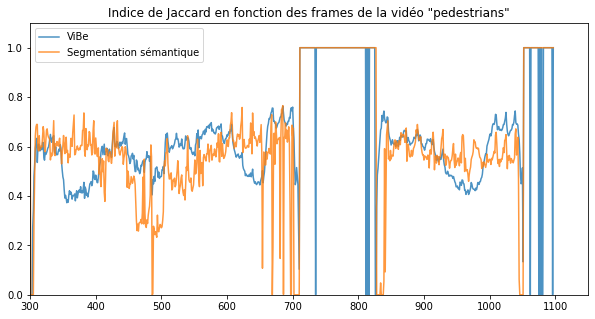

In [12]:
plt.figure(figsize=(10,5))
plt.plot(range(299,len(groundtruth_of_label)+298),jaccard_coeff_vibe,alpha=0.8,label="ViBe")
plt.plot(range(299,len(groundtruth_of_label)+298),jaccard_coeff_sem_seg,alpha=0.8,label="Segmentation sémantique")
plt.title('Indice de Jaccard en fonction des frames de la vidéo "pedestrians"')
plt.ylim([0,1.1])
plt.xlim([300,1150])
plt.legend()
plt.show()

In [17]:
label="pedestrians"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
target_frames=list(range(344,430))+list(range(579,666))+list(range(858,1010))
for i in target_frames:
    out_sem_seg=io.imread(output_data_sem_seg[label][i])
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i])
    grdtruth=io.imread(groundTruth_data[label][i])
    grdtruth[grdtruth<=170]=0
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

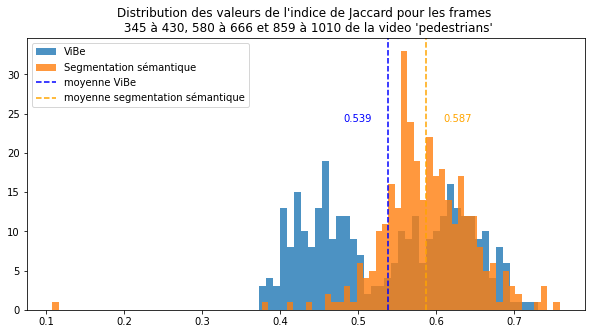

In [18]:
plt.figure(figsize=(10,5))
plt.hist(jaccard_coeff_vibe,bins=40,alpha=0.8,label="ViBe")
plt.hist(jaccard_coeff_sem_seg,bins=80,alpha=0.8,label="Segmentation sémantique")
plt.axvline(np.mean(jaccard_coeff_vibe), color="blue", ls="--",label="moyenne ViBe")
plt.axvline(np.mean(jaccard_coeff_sem_seg), color="orange", ls="--",label="moyenne segmentation sémantique")
plt.text(np.mean(jaccard_coeff_vibe)-0.04,25, "{:.3f}".format(np.mean(jaccard_coeff_vibe)), color='blue',
            ha='center', va='top')
plt.text(np.mean(jaccard_coeff_sem_seg)+0.04,25, "{:.3f}".format(np.mean(jaccard_coeff_sem_seg)), color='orange',
            ha='center', va='top')
plt.title("Distribution des valeurs de l'indice de Jaccard pour les frames \n 345 à 430, 580 à 666 et 859 à 1010 de la video 'pedestrians'")
plt.legend()
plt.show()

#### Pour le label "office" <a class="anchor" id="perf-office"></a>

In [80]:
label="office"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][569:]
for i in range(len(groundtruth_of_label)-1):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+569])
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+569])
    grdtruth=io.imread(groundtruth_of_label[i])
    grdtruth[grdtruth>=50]=255
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

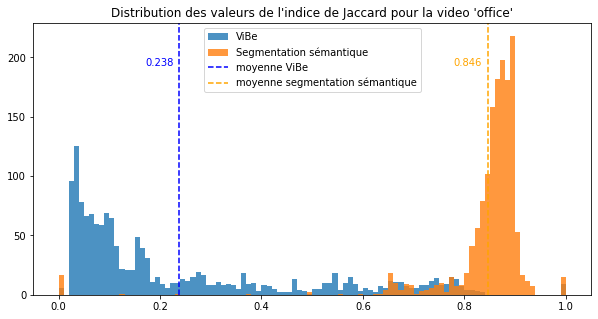

In [81]:
plt.figure(figsize=(10,5))
plt.hist(jaccard_coeff_vibe,bins=100,alpha=0.8,label="ViBe")
plt.hist(jaccard_coeff_sem_seg,bins=100,alpha=0.8,label="Segmentation sémantique")
plt.axvline(np.mean(jaccard_coeff_vibe), color="blue", ls="--",label="moyenne ViBe")
plt.text(np.mean(jaccard_coeff_vibe)-0.04,200, "{:.3f}".format(np.mean(jaccard_coeff_vibe)), color='blue',
            ha='center', va='top')
plt.text(np.mean(jaccard_coeff_sem_seg)-0.04,200, "{:.3f}".format(np.mean(jaccard_coeff_sem_seg)), color='orange',
            ha='center', va='top')
plt.axvline(np.mean(jaccard_coeff_sem_seg), color="orange", ls="--",label="moyenne segmentation sémantique")
plt.title("Distribution des valeurs de l'indice de Jaccard pour la video 'office'")
plt.legend()
plt.show()

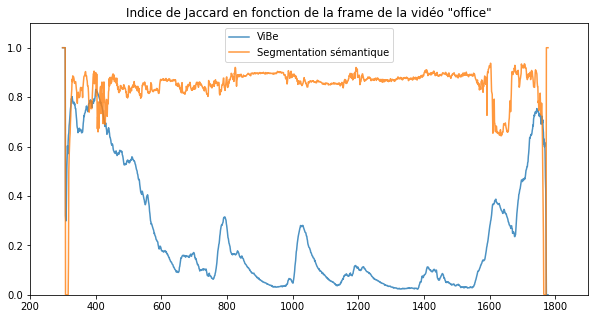

In [54]:
plt.figure(figsize=(10,5))
plt.plot(range(299,len(groundtruth_of_label)+298),jaccard_coeff_vibe,alpha=0.8,label="ViBe")
plt.plot(range(299,len(groundtruth_of_label)+298),jaccard_coeff_sem_seg,alpha=0.8,label="Segmentation sémantique")
plt.title('Indice de Jaccard en fonction de la frame de la vidéo "office"')
plt.ylim([0,1.1])
plt.xlim([200,1900])
plt.legend()
plt.show()

#### Pour le label "PETS2006" <a class="anchor" id="perf-pets"></a>

In [111]:
label="PETS2006"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][299:]
for i in range(len(groundtruth_of_label)-1):
    out_sem_seg=io.imread(output_data_sem_seg[label][i+299])
    out_sem_seg[out_sem_seg==169]=0
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i+299])
    grdtruth=io.imread(groundtruth_of_label[i])
    grdtruth[grdtruth>=50]=255
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

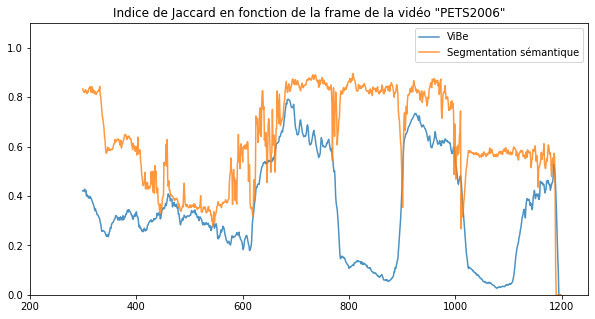

In [118]:
plt.figure(figsize=(10,5))
plt.plot(range(299,len(groundtruth_of_label)+298),jaccard_coeff_vibe,alpha=0.8,label="ViBe")
plt.plot(range(299,len(groundtruth_of_label)+298),jaccard_coeff_sem_seg,alpha=0.8,label="Segmentation sémantique")
plt.title('Indice de Jaccard en fonction de la frame de la vidéo "PETS2006"')
plt.ylim([0,1.1])
plt.xlim([200,1250])
plt.legend()
plt.show()


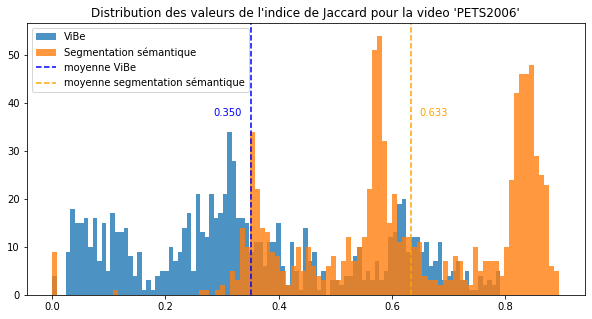

In [126]:
plt.figure(figsize=(10,5))
plt.hist(jaccard_coeff_vibe,bins=100,alpha=0.8,label="ViBe")
plt.hist(jaccard_coeff_sem_seg,bins=100,alpha=0.8,label="Segmentation sémantique")
plt.axvline(np.mean(jaccard_coeff_vibe), color="blue", ls="--",label="moyenne ViBe")
plt.text(np.mean(jaccard_coeff_vibe)-0.04,39, "{:.3f}".format(np.mean(jaccard_coeff_vibe)), color='blue',
            ha='center', va='top')
plt.text(np.mean(jaccard_coeff_sem_seg)+0.04,39, "{:.3f}".format(np.mean(jaccard_coeff_sem_seg)), color='orange',
            ha='center', va='top')
plt.axvline(np.mean(jaccard_coeff_sem_seg), color="orange", ls="--",label="moyenne segmentation sémantique")
plt.title("Distribution des valeurs de l'indice de Jaccard pour la video 'PETS2006'")
plt.legend()
plt.show()

In [92]:
label="PETS2006"
jaccard_coeff_vibe=[]
jaccard_coeff_sem_seg=[]
groundtruth_of_label=groundTruth_data[label][299:]
target_frames=list(range(786,893))+list(range(1024,1120))
for i in target_frames:
    out_sem_seg=io.imread(output_data_sem_seg[label][i])
    out_sem_seg[out_sem_seg==169]=0
    out_sem_seg[out_sem_seg==188]=255
    out_vibe=io.imread(output_data_vibe[label][i])
    grdtruth=io.imread(groundTruth_data[label][i])
    grdtruth[grdtruth>=50]=255
    jaccard_coeff_vibe.append(jaccardCoeff(out_vibe,grdtruth))
    jaccard_coeff_sem_seg.append(jaccardCoeff(out_sem_seg,grdtruth))

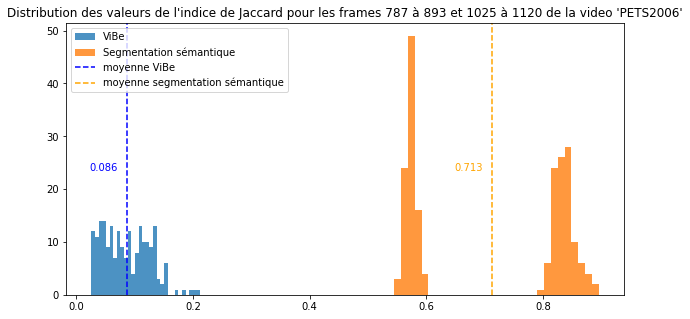

In [109]:
plt.figure(figsize=(10,5))
plt.hist(jaccard_coeff_vibe,bins=30,alpha=0.8,label="ViBe")
plt.hist(jaccard_coeff_sem_seg,bins=30,alpha=0.8,label="Segmentation sémantique")
plt.axvline(np.mean(jaccard_coeff_vibe), color="blue", ls="--",label="moyenne ViBe")
plt.text(np.mean(jaccard_coeff_vibe)-0.04,25, "{:.3f}".format(np.mean(jaccard_coeff_vibe)), color='blue',
            ha='center', va='top')
plt.text(np.mean(jaccard_coeff_sem_seg)-0.04,25, "{:.3f}".format(np.mean(jaccard_coeff_sem_seg)), color='orange',
            ha='center', va='top')
plt.axvline(np.mean(jaccard_coeff_sem_seg), color="orange", ls="--",label="moyenne segmentation sémantique")
plt.title("Distribution des valeurs de l'indice de Jaccard pour les frames 787 à 893 et 1025 à 1120 de la video 'PETS2006'")
plt.legend()
plt.show()